<a href="https://colab.research.google.com/github/HyelinNAM/TIL/blob/master/0226_Pytorch(official)_DCGAN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

%matplotlib inline

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Set random seed for reproductibility 
manualSeed = 999
print("Random seed:",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed: 999


In [0]:
dataroot = 'TIL/'

workers = 2

batch_size = 128

image_size = 64

nc = 3

nz = 100

ngf = 64

ndf = 64

num_epochs = 5

lr = 0.0002

beta1 = 0.5

ngpu = 1

In [4]:
!git clone https://github.com/HyelinNAM/TIL.git

Cloning into 'TIL'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 202525 (delta 20), reused 0 (delta 0), pack-reused 202471
Receiving objects: 100% (202525/202525), 1.29 GiB | 40.68 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Checking out files: 100% (202610/202610), done.


In [5]:
!ls

sample_data  TIL


In [0]:
dataset = dset.ImageFolder(root=dataroot,
                           transform= transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))                             
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 202599
    Root location: TIL/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

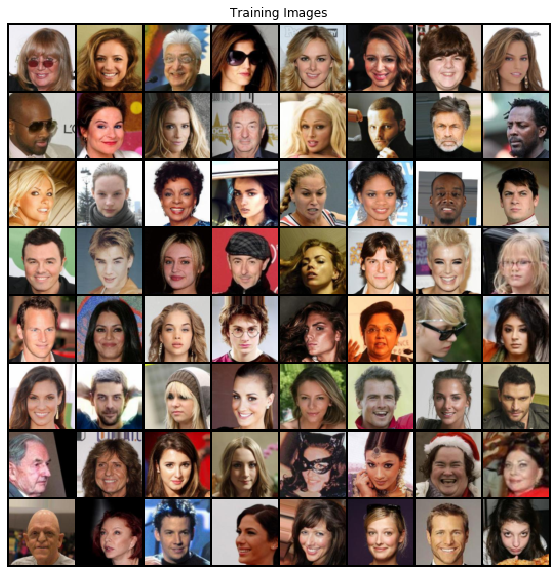

In [8]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
def weights_init(m):
  classname = m.__class__.__name__

  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0,0.02)
  
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

In [0]:
# Generator

class Generator(nn.Module):
  def __init__(self,ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input : z 벡터
        nn.ConvTranspose2d(in_channels=nz,out_channels=ngf*8,kernel_size=4,stride=1,padding=0, bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True),
        # state size. (ngf*8)*4*4
        nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        # (ngf*4)*8*8
        nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),
        # (ngf*2)*16*16
        nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # ngf * 32 * 32
        nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
        nn.Tanh()
        # nc * 64 *64
    )

  def forward(self,input):
    return self.main(input)

In [12]:
netG = Generator(ngpu).to(device)

if (device.type=='cuda') and (ngpu>1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [0]:
# Discriminator

class Discriminator(nn.Module):
  def __init__(self,ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input : nc * 64 * 64
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        # ndf * 32 * 32
        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,inplace=True),
        # (ndf*2) * 16 *16
        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,inplace=True),
        # (ndf*4)*8*8
        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2,inplace=True),
        # (ndf*8)*4*4
        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        nn.Sigmoid()
    )

  def forward(self,input):
    return self.main(input)

In [18]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64,nz,1,1,device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

In [38]:
for i, data in enumerate(dataloader,0):
  print(i)
  real_cpu = data[0]
  print(real_cpu.shape)
  #print(real_cpu)
  b_size = real_cpu.size(0)
  print(real_cpu.size)
  print(b_size)
  label = torch.full((b_size,), real_label, device=device)
  print(label)
  break

0
torch.Size([128, 3, 64, 64])
<built-in method size of Tensor object at 0x7f40a01da090>
128
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')


In [34]:
# Training

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

#for each epoch
for epoch in range(num_epochs):
  # for each batch
  for i, data in enumerate(dataloader,0):
    
    # Update D

    # train with all-real batch
    netD.zero_grad()
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, device=device)

    output = netD(real_cpu).view(-1)
    errD_real = criterion(output,label)
    errD_real.backward()
    D_x = output.mean().item()

    # train with all-fake batch
    noise = torch.randn(b_size,nz,1,1,device=device)
    fake = netG(noise)
    label.fill_(fake_label)

    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output,label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake

    optimizerD.step()

    # Update G
    netG.zero_grad()
    label.fill_(real_label)
    
    output = netD(fake).view(-1)
    errG = criterion(output,label)
    errG.backward()
    D_G_z2 = output.mean().item()
    
    optimizerG.step()

    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      
      G_losses.append(errG.item())
      D_losses.append(errD.item())

      if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 0.8461	Loss_G: 0.7463	D(x): 0.5087	D(G(z)): 0.0259 / 0.5387
[0/5][50/1583]	Loss_D: 0.5712	Loss_G: 3.0849	D(x): 0.6649	D(G(z)): 0.0721 / 0.0762
[0/5][100/1583]	Loss_D: 0.3744	Loss_G: 3.0584	D(x): 0.9078	D(G(z)): 0.2176 / 0.0674
[0/5][150/1583]	Loss_D: 0.5480	Loss_G: 2.1982	D(x): 0.6531	D(G(z)): 0.0437 / 0.1619
[0/5][200/1583]	Loss_D: 1.3476	Loss_G: 5.1105	D(x): 0.9301	D(G(z)): 0.6037 / 0.0166
[0/5][250/1583]	Loss_D: 0.3965	Loss_G: 2.6584	D(x): 0.7389	D(G(z)): 0.0507 / 0.1044
[0/5][300/1583]	Loss_D: 0.2673	Loss_G: 3.0223	D(x): 0.8969	D(G(z)): 0.1252 / 0.0681
[0/5][350/1583]	Loss_D: 0.5397	Loss_G: 2.1761	D(x): 0.6472	D(G(z)): 0.0272 / 0.1747
[0/5][400/1583]	Loss_D: 0.5166	Loss_G: 3.3972	D(x): 0.8296	D(G(z)): 0.2421 / 0.0475
[0/5][450/1583]	Loss_D: 0.2901	Loss_G: 3.0091	D(x): 0.8631	D(G(z)): 0.1173 / 0.0717
[0/5][500/1583]	Loss_D: 0.3318	Loss_G: 4.0753	D(x): 0.9611	D(G(z)): 0.2340 / 0.0219
[0/5][550/1583]	Loss_D: 0.2785	Loss_G: 3.9356	D(x): 0

In [29]:
len(G_losses)

160

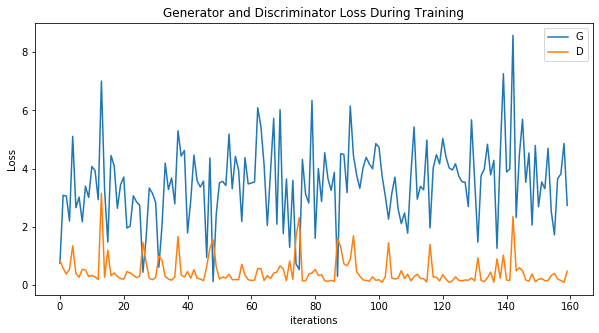

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

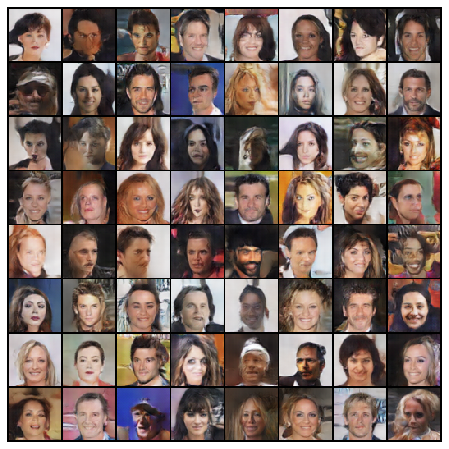

In [42]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

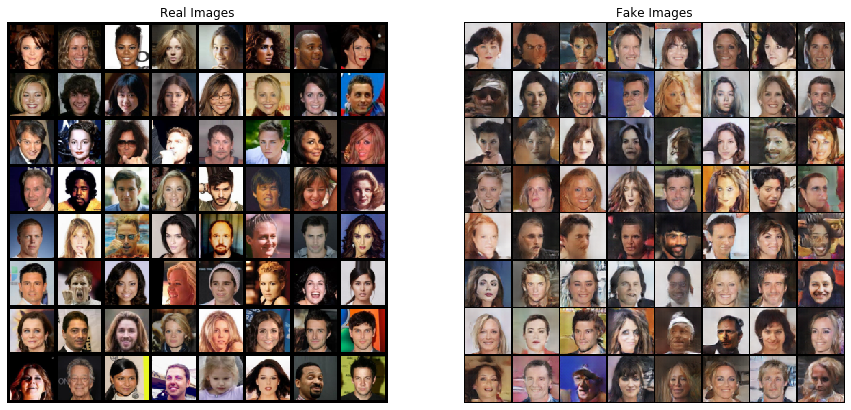

In [41]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()